Intro to  adsorption energies
==================================================

To introduce OCP we start with using it to calculate adsorption energies for a simple, atomic adsorbate where we specify the site we want to the adsorption energy for. Conceptually, you do this like you would do it with density functional theory. You create a slab model for the surface, place an adsorbate on it as an initial guess, run a relaxation to get the lowest energy geometry, and then compute the adsorption energy using reference states for the adsorbate.

You do have to be careful in the details though. Some OCP model/checkpoint combinations return a total energy like density functional theory would, but some return an "adsorption energy" directly. You have to know which one you are using. In this example, the model we use returns an "adsorption energy".

## Intro to Adsorption energies

Adsorption energies are always a reaction energy (an adsorbed species relative to some implied combination of reactants). There are many common schemes in the catalysis literature.

For example, you may want the adsorption energy of oxygen, and you might compute that from this reaction:

    1/2 O2 + slab -> slab-O

DFT has known errors with the energy of a gas-phase O2 molecule, so it's more common to compute this energy relative to a linear combination of H2O and H2. The suggested reference scheme for consistency with OC20 is a reaction

    x CO + (x + y/2 - z) H2 + (z-x) H2O + w/2 N2 + * -> CxHyOzNw*

Here, x=y=w=0, z=1, so the reaction ends up as

    -H2 + H2O + * -> O*

or alternatively,

    H2O + * -> O* + H2

It is possible through thermodynamic cycles to compute other reactions. If we can look up rH1 below and compute rH2

    H2 + 1/2 O2 -> H2O  re1 = -3.03 eV, from exp
    H2O + * -> O* + H2  re2  # Get from UMA

Then, the adsorption energy for

    1/2O2 + * -> O*

is just re1 + re2.

Based on https://atct.anl.gov/Thermochemical%20Data/version%201.118/species/?species_number=986, the formation energy of water is about -3.03 eV at standard state experimentally. You could also compute this using DFT, but you would probably get the wrong answer for this.

The first step is getting a checkpoint for the model we want to use. UMA is currently the state-of-the-art model and will provide total energy estimates at the RPBE level of theory if you use the "OC20" task.


````{admonition} Need to install fairchem-core or get UMA access or getting permissions/401 errors?
:class: dropdown


1. Install the necessary packages using pip, uv etc
```{code-cell} ipython3
:tags: [skip-execution]

! pip install fairchem-core fairchem-data-oc fairchem-applications-cattsunami
```

2. Get access to any necessary huggingface gated models
    * Get and login to your Huggingface account
    * Request access to https://huggingface.co/facebook/UMA
    * Create a Huggingface token at https://huggingface.co/settings/tokens/ with the permission "Permissions: Read access to contents of all public gated repos you can access"
    * Add the token as an environment variable using `huggingface-cli login` or by setting the HF_TOKEN environment variable.

```{code-cell} ipython3
:tags: [skip-execution]

# Login using the huggingface-cli utility
! huggingface-cli login

# alternatively,
import os
os.environ['HF_TOKEN'] = 'MY_TOKEN'
```

````

If you find your kernel is crashing, it probably means you have exceeded the allowed amount of memory. This checkpoint works fine in this example, but it may crash your kernel if you use it in the NRR example.

This next cell will automatically download the checkpoint from huggingface and load it.

In [1]:
from __future__ import annotations

from fairchem.core import FAIRChemCalculator, pretrained_mlip

predictor = pretrained_mlip.get_predict_unit("uma-s-1p1")
calc = FAIRChemCalculator(predictor, task_name="oc20")

Next we can build a slab with an adsorbate on it. Here we use the ASE module to build a Pt slab. We use the experimental lattice constant that is the default. This can introduce some small errors with DFT since the lattice constant can differ by a few percent, and it is common to use DFT lattice constants. In this example, we do not constrain any layers.

In [2]:
from ase.build import add_adsorbate, fcc111
from ase.optimize import BFGS

In [3]:
# reference energies from a linear combination of H2O/N2/CO/H2!
atomic_reference_energies = {
    "H": -3.477,
    "N": -8.083,
    "O": -7.204,
    "C": -7.282,
}

re1 = -3.03

slab = fcc111("Pt", size=(2, 2, 5), vacuum=20.0)
slab.pbc = True

adslab = slab.copy()
add_adsorbate(adslab, "O", height=1.2, position="fcc")

slab.set_calculator(calc)
opt = BFGS(slab)
opt.run(fmax=0.05, steps=100)
slab_e = slab.get_potential_energy()

adslab.set_calculator(calc)
opt = BFGS(adslab)
opt.run(fmax=0.05, steps=100)
adslab_e = adslab.get_potential_energy()

# Energy for ((H2O-H2) + * -> *O) + (H2 + 1/2O2 -> H2) leads to 1/2O2 + * -> *O!
adslab_e - slab_e - atomic_reference_energies["O"] + re1

/tmp/ipykernel_5638/3752951811.py:17: FutureWarning: Please use atoms.calc = calc
  slab.set_calculator(calc)


      Step     Time          Energy          fmax
BFGS:    0 19:20:41     -104.695193        0.709590


BFGS:    1 19:20:41     -104.753188        0.607748


BFGS:    2 19:20:41     -104.906057        0.369388


BFGS:    3 19:20:41     -104.938753        0.439757


BFGS:    4 19:20:41     -105.016144        0.464013


BFGS:    5 19:20:41     -105.076561        0.356059


BFGS:    6 19:20:41     -105.112621        0.189414


BFGS:    7 19:20:41     -105.126757        0.045374


      Step     Time          Energy          fmax
BFGS:    0 19:20:41     -110.048789        1.757515


BFGS:    1 19:20:41     -110.230720        0.986276


/tmp/ipykernel_5638/3752951811.py:22: FutureWarning: Please use atoms.calc = calc
  adslab.set_calculator(calc)


BFGS:    2 19:20:41     -110.379352        0.731504


BFGS:    3 19:20:41     -110.430289        0.807338


BFGS:    4 19:20:42     -110.543669        0.692011


BFGS:    5 19:20:42     -110.617475        0.492756


BFGS:    6 19:20:42     -110.673456        0.666978


BFGS:    7 19:20:42     -110.721678        0.710551


BFGS:    8 19:20:42     -110.756902        0.443852


BFGS:    9 19:20:42     -110.769292        0.214549


BFGS:   10 19:20:42     -110.772453        0.091743


BFGS:   11 19:20:42     -110.772964        0.062472


BFGS:   12 19:20:42     -110.773258        0.046193


-1.4725015361139024

It is good practice to look at your geometries to make sure they are what you expect.

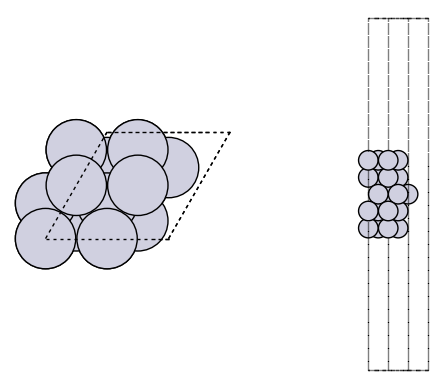

In [4]:
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms

fig, axs = plt.subplots(1, 2)
plot_atoms(slab, axs[0])
plot_atoms(slab, axs[1], rotation=("-90x"))
axs[0].set_axis_off()
axs[1].set_axis_off()

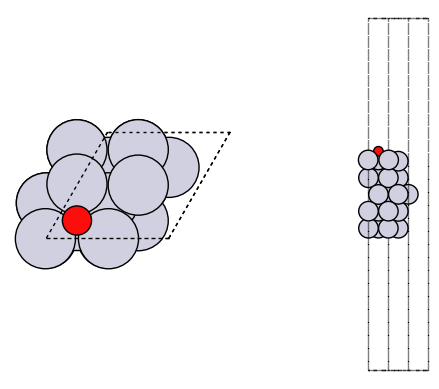

In [5]:
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms

fig, axs = plt.subplots(1, 2)
plot_atoms(adslab, axs[0])
plot_atoms(adslab, axs[1], rotation=("-90x"))
axs[0].set_axis_off()
axs[1].set_axis_off()

How did we do? We need a reference point. In the paper below, there is an atomic adsorption energy for O on Pt(111) of about -4.264 eV. This is for the reaction O + * -> O*. To convert this to the dissociative adsorption energy, we have to add the reaction:

    1/2 O2 -> O   D = 2.58 eV (expt)

to get a comparable energy of about -1.68 eV. There is about ~0.2 eV difference (we predicted -1.47 eV above, and the reference comparison is -1.68 eV) to account for. The biggest difference is likely due to the differences in exchange-correlation functional. The reference data used the PBE functional, and eSCN was trained on *RPBE* data. To additional places where there are differences include:

1. Difference in lattice constant
2. The reference energy used for the experiment references. These can differ by up to 0.5 eV from comparable DFT calculations.
3. How many layers are relaxed in the calculation

Some of these differences tend to be systematic, and you can calibrate and correct these, especially if you can augment these with your own DFT calculations.

See [convergence study](#Convergence-study) for some additional studies of factors that influence this number.

### Exercises

1. Explore the effect of the lattice constant on the adsorption energy.
2. Try different sites, including the bridge and top sites. Compare the energies, and inspect the resulting geometries.

## Trends in adsorption energies across metals.

Xu, Z., & Kitchin, J. R. (2014). Probing the coverage dependence of site and adsorbate configurational correlations on (111) surfaces of late transition metals. J. Phys. Chem. C, 118(44), 25597–25602. http://dx.doi.org/10.1021/jp508805h

[Supporting information](https://pubs.acs.org/doi/suppl/10.1021/jp508805h/suppl_file/jp508805h_si_001.pdf).

These are atomic adsorption energies:

    O + * -> O*

We have to do some work to get comparable numbers from OCP

    H2 + 1/2 O2 -> H2O  re1 = -3.03 eV
    H2O + * -> O* + H2  re2   # Get from UMA
    O -> 1/2 O2         re3 = -2.58 eV

Then, the adsorption energy for

    O + * -> O*

is just re1 + re2 + re3.

Here we just look at the fcc site on Pt. First, we get the data stored in the paper.

Next we get the structures and compute their energies. Some subtle points are that we have to account for stoichiometry, and normalize the adsorption energy by the number of oxygens.

First we get a reference energy from the paper (PBE, 0.25 ML O on Pt(111)).

In [6]:
import json

with open("energies.json") as f:
    edata = json.load(f)

with open("structures.json") as f:
    sdata = json.load(f)

edata["Pt"]["O"]["fcc"]["0.25"]

-4.263842000000002

Next, we load data from the SI to get the geometry to start from.

In [7]:
with open("structures.json") as f:
    s = json.load(f)

sfcc = s["Pt"]["O"]["fcc"]["0.25"]

Next, we construct the atomic geometry, run the geometry optimization, and compute the energy.

In [8]:
re3 = -2.58  # O -> 1/2 O2         re3 = -2.58 eV

from ase import Atoms

adslab = Atoms(sfcc["symbols"], positions=sfcc["pos"], cell=sfcc["cell"], pbc=True)

# Grab just the metal surface atoms
slab = adslab[adslab.arrays["numbers"] == adslab.arrays["numbers"][0]]
adsorbates = adslab[~(adslab.arrays["numbers"] == adslab.arrays["numbers"][0])]
slab.set_calculator(calc)
opt = BFGS(slab)
opt.run(fmax=0.05, steps=100)

adslab.set_calculator(calc)
opt = BFGS(adslab)

opt.run(fmax=0.05, steps=100)
re2 = (
    adslab.get_potential_energy()
    - slab.get_potential_energy()
    - sum([atomic_reference_energies[x] for x in adsorbates.get_chemical_symbols()])
)

nO = 0
for atom in adslab:
    if atom.symbol == "O":
        nO += 1
        re2 += re1 + re3

print(re2 / nO)

      Step     Time          Energy          fmax
BFGS:    0 19:20:44      -82.862062        1.000262


BFGS:    1 19:20:45      -82.918113        0.752919


/tmp/ipykernel_5638/647904475.py:10: FutureWarning: Please use atoms.calc = calc
  slab.set_calculator(calc)


BFGS:    2 19:20:45      -83.011695        0.335860


BFGS:    3 19:20:45      -83.016496        0.303120


BFGS:    4 19:20:45      -83.024495        0.224962


BFGS:    5 19:20:45      -83.030036        0.152566


BFGS:    6 19:20:45      -83.033361        0.088625


BFGS:    7 19:20:45      -83.034469        0.065747


BFGS:    8 19:20:45      -83.035207        0.068690


BFGS:    9 19:20:45      -83.035564        0.046754


      Step     Time          Energy          fmax
BFGS:    0 19:20:46      -88.770343        0.312349


BFGS:    1 19:20:46      -88.773631        0.271703


/tmp/ipykernel_5638/647904475.py:14: FutureWarning: Please use atoms.calc = calc
  adslab.set_calculator(calc)


BFGS:    2 19:20:46      -88.784473        0.104050


BFGS:    3 19:20:46      -88.786013        0.101458


BFGS:    4 19:20:46      -88.788553        0.106391


BFGS:    5 19:20:46      -88.790501        0.089087


BFGS:    6 19:20:46      -88.791972        0.096448


BFGS:    7 19:20:46      -88.792657        0.099419


BFGS:    8 19:20:46      -88.793180        0.077362


BFGS:    9 19:20:46      -88.793679        0.036098


-4.164116240245982


### Site correlations

This cell reproduces a portion of a figure in the paper. We compare oxygen adsorption energies in the fcc and hcp sites across metals and coverages. These adsorption energies are highly correlated with each other because the adsorption sites are so similar.

At higher coverages, the agreement is not as good. This is likely because the model is extrapolating and needs to be fine-tuned.

In [9]:
import time

from tqdm import tqdm

t0 = time.time()

data = {"fcc": [], "hcp": []}

refdata = {"fcc": [], "hcp": []}


for metal in ["Cu", "Ag", "Pd", "Pt", "Rh", "Ir"]:
    print(metal)
    for site in ["fcc", "hcp"]:
        for adsorbate in ["O"]:
            for coverage in tqdm(["0.25"]):

                entry = s[metal][adsorbate][site][coverage]

                adslab = Atoms(
                    entry["symbols"],
                    positions=entry["pos"],
                    cell=entry["cell"],
                    pbc=True,
                )

                # Grab just the metal surface atoms
                adsorbates = adslab[
                    ~(adslab.arrays["numbers"] == adslab.arrays["numbers"][0])
                ]

                slab = adslab[adslab.arrays["numbers"] == adslab.arrays["numbers"][0]]
                slab.set_calculator(calc)
                opt = BFGS(slab)
                opt.run(fmax=0.05, steps=100)

                adslab.set_calculator(calc)
                opt = BFGS(adslab)
                opt.run(fmax=0.05, steps=100)

                re2 = (
                    adslab.get_potential_energy()
                    - slab.get_potential_energy()
                    - sum(
                        [
                            atomic_reference_energies[x]
                            for x in adsorbates.get_chemical_symbols()
                        ]
                    )
                )

                nO = 0
                for atom in adslab:
                    if atom.symbol == "O":
                        nO += 1
                        re2 += re1 + re3

                data[site] += [re2 / nO]
                refdata[site] += [edata[metal][adsorbate][site][coverage]]

f"Elapsed time = {time.time() - t0} seconds"

Cu


  0%|          | 0/1 [00:00<?, ?it/s]

      Step     Time          Energy          fmax
BFGS:    0 19:20:46      -48.910948        0.646351


BFGS:    1 19:20:47      -48.934031        0.539303


/tmp/ipykernel_5638/1356342052.py:33: FutureWarning: Please use atoms.calc = calc
  slab.set_calculator(calc)


BFGS:    2 19:20:47      -49.000043        0.280103


BFGS:    3 19:20:47      -49.002374        0.251321


BFGS:    4 19:20:47      -49.008810        0.158909


BFGS:    5 19:20:47      -49.013986        0.134399


BFGS:    6 19:20:47      -49.016868        0.071527


BFGS:    7 19:20:47      -49.017633        0.051269


BFGS:    8 19:20:47      -49.018012        0.047563


      Step     Time          Energy          fmax
BFGS:    0 19:20:47      -55.204221        0.339047


BFGS:    1 19:20:47      -55.206662        0.267937


/tmp/ipykernel_5638/1356342052.py:37: FutureWarning: Please use atoms.calc = calc
  adslab.set_calculator(calc)


BFGS:    2 19:20:47      -55.213711        0.160041


BFGS:    3 19:20:47      -55.215874        0.166182


BFGS:    4 19:20:48      -55.219674        0.116685


BFGS:    5 19:20:48      -55.221813        0.079419


BFGS:    6 19:20:48      -55.223360        0.075349


BFGS:    7 19:20:48      -55.224365        0.090294


BFGS:    8 19:20:48      -55.225517        0.098891


BFGS:    9 19:20:48      -55.226529        0.068543


BFGS:   10 19:20:48      -55.226977        0.042994


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

      Step     Time          Energy          fmax
BFGS:    0 19:20:48      -48.936503        0.552695


BFGS:    1 19:20:48      -48.954084        0.470533


BFGS:    2 19:20:48      -49.008577        0.210998


BFGS:    3 19:20:48      -49.009768        0.197685


BFGS:    4 19:20:49      -49.017746        0.041126


      Step     Time          Energy          fmax
BFGS:    0 19:20:49      -55.119070        0.305598


BFGS:    1 19:20:49      -55.120918        0.239016


BFGS:    2 19:20:49      -55.125705        0.129128


BFGS:    3 19:20:49      -55.127340        0.147616


BFGS:    4 19:20:49      -55.130396        0.128639


BFGS:    5 19:20:49      -55.132308        0.103135


BFGS:    6 19:20:49      -55.133381        0.051684


BFGS:    7 19:20:49      -55.133851        0.056050


BFGS:    8 19:20:49      -55.134357        0.071226


BFGS:    9 19:20:49      -55.135043        0.069443


BFGS:   10 19:20:49      -55.135574        0.039935


100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

Ag


  0%|          | 0/1 [00:00<?, ?it/s]

      Step     Time          Energy          fmax
BFGS:    0 19:20:50      -33.034314        0.634820


BFGS:    1 19:20:50      -33.053470        0.551048


BFGS:    2 19:20:50      -33.120905        0.172022


BFGS:    3 19:20:50      -33.122778        0.157330


BFGS:    4 19:20:50      -33.124181        0.143386


BFGS:    5 19:20:50      -33.126944        0.112458


BFGS:    6 19:20:50      -33.130772        0.110656


BFGS:    7 19:20:50      -33.133994        0.067529


BFGS:    8 19:20:50      -33.134834        0.034888


      Step     Time          Energy          fmax
BFGS:    0 19:20:50      -38.173509        0.098015


BFGS:    1 19:20:50      -38.174435        0.094365


BFGS:    2 19:20:51      -38.184909        0.084033


BFGS:    3 19:20:51      -38.185732        0.085434


BFGS:    4 19:20:51      -38.189035        0.086084


BFGS:    5 19:20:51      -38.190953        0.068838


BFGS:    6 19:20:51      -38.192256        0.087465


BFGS:    7 19:20:51      -38.193187        0.076889


BFGS:    8 19:20:51      -38.193674        0.042576


100%|██████████| 1/1 [00:01<00:00,  1.57s/it]

100%|██████████| 1/1 [00:01<00:00,  1.57s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

      Step     Time          Energy          fmax
BFGS:    0 19:20:51      -33.056750        0.557366


BFGS:    1 19:20:51      -33.071228        0.489412


BFGS:    2 19:20:51      -33.126397        0.123825


BFGS:    3 19:20:51      -33.127308        0.112960


BFGS:    4 19:20:52      -33.128515        0.097373


BFGS:    5 19:20:52      -33.130260        0.079535


BFGS:    6 19:20:52      -33.133160        0.076346


BFGS:    7 19:20:52      -33.134741        0.040732


      Step     Time          Energy          fmax
BFGS:    0 19:20:52      -38.102026        0.092717


BFGS:    1 19:20:52      -38.102856        0.088836


BFGS:    2 19:20:52      -38.111088        0.134657


BFGS:    3 19:20:52      -38.112011        0.120324


BFGS:    4 19:20:52      -38.115289        0.063997


BFGS:    5 19:20:52      -38.116156        0.056403


BFGS:    6 19:20:52      -38.116711        0.058194


BFGS:    7 19:20:52      -38.117580        0.073165


BFGS:    8 19:20:52      -38.118453        0.057904


BFGS:    9 19:20:53      -38.118835        0.026051


100%|██████████| 1/1 [00:01<00:00,  1.58s/it]

100%|██████████| 1/1 [00:01<00:00,  1.58s/it]

Pd


  0%|          | 0/1 [00:00<?, ?it/s]

      Step     Time          Energy          fmax
BFGS:    0 19:20:53      -70.165062        0.631446


BFGS:    1 19:20:53      -70.189910        0.508128


BFGS:    2 19:20:53      -70.241649        0.191934


BFGS:    3 19:20:53      -70.243346        0.182565


BFGS:    4 19:20:53      -70.248576        0.144558


BFGS:    5 19:20:53      -70.251930        0.115933


BFGS:    6 19:20:53      -70.254308        0.074837


BFGS:    7 19:20:53      -70.255205        0.059447


BFGS:    8 19:20:53      -70.255944        0.041108


      Step     Time          Energy          fmax
BFGS:    0 19:20:53      -76.130241        0.213656


BFGS:    1 19:20:54      -76.133242        0.190305


BFGS:    2 19:20:54      -76.148718        0.169646


BFGS:    3 19:20:54      -76.150812        0.152254


BFGS:    4 19:20:54      -76.154313        0.130504


BFGS:    5 19:20:54      -76.157057        0.106138


BFGS:    6 19:20:54      -76.159302        0.088117


BFGS:    7 19:20:54      -76.160430        0.080502


BFGS:    8 19:20:54      -76.161130        0.064502


BFGS:    9 19:20:54      -76.161614        0.042988


100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

      Step     Time          Energy          fmax
BFGS:    0 19:20:54      -70.197712        0.454636


BFGS:    1 19:20:54      -70.211774        0.373893


BFGS:    2 19:20:55      -70.245977        0.178178


BFGS:    3 19:20:55      -70.247162        0.164572


BFGS:    4 19:20:55      -70.253348        0.078706


BFGS:    5 19:20:55      -70.254511        0.075507


BFGS:    6 19:20:55      -70.255272        0.058129


BFGS:    7 19:20:55      -70.255844        0.036952


      Step     Time          Energy          fmax
BFGS:    0 19:20:55      -75.892387        0.169440


BFGS:    1 19:20:55      -75.895234        0.150799


BFGS:    2 19:20:55      -75.906632        0.144106


BFGS:    3 19:20:55      -75.908424        0.135658


BFGS:    4 19:20:55      -75.912428        0.129018


BFGS:    5 19:20:55      -75.915496        0.108689


BFGS:    6 19:20:56      -75.917927        0.075293


BFGS:    7 19:20:56      -75.918956        0.067259


BFGS:    8 19:20:56      -75.919478        0.044573


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

Pt


  0%|          | 0/1 [00:00<?, ?it/s]

      Step     Time          Energy          fmax
BFGS:    0 19:20:56      -82.862062        1.000262


BFGS:    1 19:20:56      -82.918113        0.752920


BFGS:    2 19:20:56      -83.011694        0.335860


BFGS:    3 19:20:56      -83.016496        0.303120


BFGS:    4 19:20:56      -83.024495        0.224963


BFGS:    5 19:20:56      -83.030036        0.152566


BFGS:    6 19:20:56      -83.033360        0.088624


BFGS:    7 19:20:56      -83.034468        0.065747


BFGS:    8 19:20:57      -83.035207        0.068691


BFGS:    9 19:20:57      -83.035564        0.046754


      Step     Time          Energy          fmax
BFGS:    0 19:20:57      -88.770343        0.312348


BFGS:    1 19:20:57      -88.773630        0.271703


BFGS:    2 19:20:57      -88.784473        0.104050


BFGS:    3 19:20:57      -88.786014        0.101457


BFGS:    4 19:20:57      -88.788552        0.106389


BFGS:    5 19:20:57      -88.790502        0.089092


BFGS:    6 19:20:57      -88.791972        0.096441


BFGS:    7 19:20:57      -88.792659        0.099421


BFGS:    8 19:20:57      -88.793180        0.077380


BFGS:    9 19:20:57      -88.793678        0.036114


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

      Step     Time          Energy          fmax
BFGS:    0 19:20:58      -82.946996        0.675644


BFGS:    1 19:20:58      -82.973149        0.546704


BFGS:    2 19:20:58      -83.026506        0.203004


BFGS:    3 19:20:58      -83.028070        0.183991


BFGS:    4 19:20:58      -83.033699        0.083394


BFGS:    5 19:20:58      -83.034396        0.061071


BFGS:    6 19:20:58      -83.035121        0.048392


      Step     Time          Energy          fmax
BFGS:    0 19:20:58      -88.350562        0.234982


BFGS:    1 19:20:58      -88.353607        0.203898


BFGS:    2 19:20:58      -88.362977        0.117096


BFGS:    3 19:20:58      -88.364342        0.121250


BFGS:    4 19:20:59      -88.368499        0.090132


BFGS:    5 19:20:59      -88.370483        0.073280


BFGS:    6 19:20:59      -88.371785        0.075222


BFGS:    7 19:20:59      -88.372317        0.079581


BFGS:    8 19:20:59      -88.372729        0.061421


BFGS:    9 19:20:59      -88.373020        0.027206


100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

Rh


  0%|          | 0/1 [00:00<?, ?it/s]

      Step     Time          Energy          fmax
BFGS:    0 19:20:59     -100.192566        0.688933


BFGS:    1 19:20:59     -100.218240        0.600213


BFGS:    2 19:20:59     -100.286833        0.174739


BFGS:    3 19:20:59     -100.289767        0.129382


BFGS:    4 19:20:59     -100.298130        0.066639


BFGS:    5 19:21:00     -100.299264        0.053478


BFGS:    6 19:21:00     -100.299778        0.045083


      Step     Time          Energy          fmax
BFGS:    0 19:21:00     -106.921794        0.203149


BFGS:    1 19:21:00     -106.924542        0.168907


BFGS:    2 19:21:00     -106.930976        0.052441


BFGS:    3 19:21:00     -106.931584        0.045559


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

      Step     Time          Energy          fmax
BFGS:    0 19:21:00     -100.171741        0.714774


BFGS:    1 19:21:00     -100.203866        0.626030


BFGS:    2 19:21:00     -100.287846        0.263192


BFGS:    3 19:21:00     -100.290543        0.195991


BFGS:    4 19:21:00     -100.297165        0.080377


BFGS:    5 19:21:01     -100.299033        0.056460


BFGS:    6 19:21:01     -100.299772        0.043871


      Step     Time          Energy          fmax
BFGS:    0 19:21:01     -106.876839        0.168839


BFGS:    1 19:21:01     -106.879420        0.139489


BFGS:    2 19:21:01     -106.885549        0.071255


BFGS:    3 19:21:01     -106.886238        0.064286


BFGS:    4 19:21:01     -106.886581        0.054980


BFGS:    5 19:21:01     -106.886841        0.043052


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

Ir


  0%|          | 0/1 [00:00<?, ?it/s]

      Step     Time          Energy          fmax
BFGS:    0 19:21:01     -124.235610        1.189926


BFGS:    1 19:21:01     -124.310841        0.937184


BFGS:    2 19:21:01     -124.422189        0.140826


BFGS:    3 19:21:02     -124.425270        0.133780


BFGS:    4 19:21:02     -124.429598        0.060641


BFGS:    5 19:21:02     -124.430258        0.038672


      Step     Time          Energy          fmax
BFGS:    0 19:21:02     -130.605623        0.371645


BFGS:    1 19:21:02     -130.616146        0.265891


BFGS:    2 19:21:02     -130.630316        0.110764


BFGS:    3 19:21:02     -130.633615        0.094357


BFGS:    4 19:21:02     -130.634277        0.075693


BFGS:    5 19:21:02     -130.634991        0.065693


BFGS:    6 19:21:02     -130.636199        0.083039


BFGS:    7 19:21:02     -130.636657        0.075132


BFGS:    8 19:21:02     -130.637048        0.047444


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

      Step     Time          Energy          fmax
BFGS:    0 19:21:03     -124.227591        1.165685


BFGS:    1 19:21:03     -124.311476        0.915619


BFGS:    2 19:21:03     -124.422556        0.165136


BFGS:    3 19:21:03     -124.425478        0.200268


BFGS:    4 19:21:03     -124.428763        0.168861


BFGS:    5 19:21:03     -124.430255        0.088395


BFGS:    6 19:21:03     -124.430559        0.041797


      Step     Time          Energy          fmax
BFGS:    0 19:21:03     -130.496158        0.405482


BFGS:    1 19:21:03     -130.507203        0.266991


BFGS:    2 19:21:03     -130.518616        0.126414


BFGS:    3 19:21:03     -130.522314        0.080268


BFGS:    4 19:21:04     -130.523180        0.066553


BFGS:    5 19:21:04     -130.523452        0.056611


BFGS:    6 19:21:04     -130.524511        0.055659


BFGS:    7 19:21:04     -130.524677        0.042695


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

'Elapsed time = 17.568216800689697 seconds'

First, we compare the computed data and reference data. There is a systematic difference of about 0.5 eV due to the difference between RPBE and PBE functionals, and other subtle differences like lattice constant differences and reference energy differences. This is pretty typical, and an expected deviation.

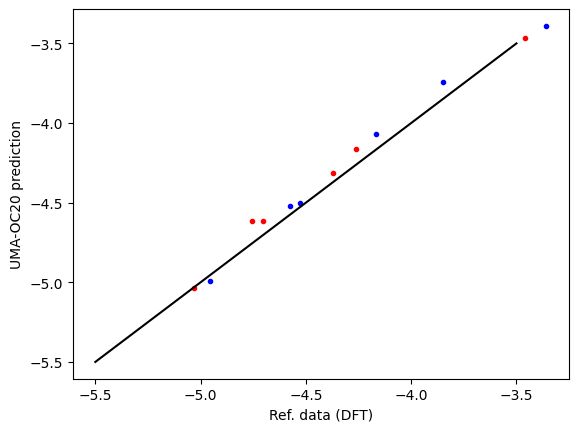

In [10]:
plt.plot(refdata["fcc"], data["fcc"], "r.", label="fcc")
plt.plot(refdata["hcp"], data["hcp"], "b.", label="hcp")
plt.plot([-5.5, -3.5], [-5.5, -3.5], "k-")
plt.xlabel("Ref. data (DFT)")
plt.ylabel("UMA-OC20 prediction");

Next we compare the correlation between the hcp and fcc sites. Here we see the same trends. The data falls below the parity line because the hcp sites tend to be a little weaker binding than the fcc sites.

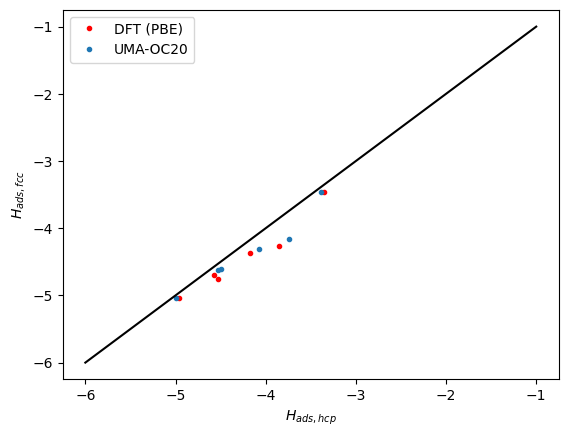

In [11]:
plt.plot(refdata["hcp"], refdata["fcc"], "r.")
plt.plot(data["hcp"], data["fcc"], ".")
plt.plot([-6, -1], [-6, -1], "k-")
plt.xlabel("$H_{ads, hcp}$")
plt.ylabel("$H_{ads, fcc}$")
plt.legend(["DFT (PBE)", "UMA-OC20"]);

### Exercises

1. You can also explore a few other adsorbates: C, H, N.
2. Explore the higher coverages. The deviations from the reference data are expected to be higher, but relative differences tend to be better. You probably need fine tuning to improve this performance. This data set doesn't have forces though, so it isn't practical to do it here.

## Next steps

In the next step, we consider some more complex adsorbates in nitrogen reduction, and how we can leverage OCP to automate the search for the most stable adsorbate geometry. See [the next step](./NRR/NRR_example-gemnet).

### Convergence study

In [Calculating adsorption energies](#Calculating-adsorption-energies) we discussed some possible reasons we might see a discrepancy. Here we investigate some factors that impact the computed energies.

In this section, the energies refer to the reaction 1/2 O2 -> O*.

### Effects of number of layers

Slab thickness could be a factor. Here we relax the whole slab, and see by about 4 layers the energy is converged to ~0.02 eV.

In [12]:
for nlayers in [3, 4, 5, 6, 7, 8]:
    slab = fcc111("Pt", size=(2, 2, nlayers), vacuum=10.0)

    slab.pbc = True
    slab.set_calculator(calc)
    opt_slab = BFGS(slab, logfile=None)
    opt_slab.run(fmax=0.05, steps=100)
    slab_e = slab.get_potential_energy()

    adslab = slab.copy()
    add_adsorbate(adslab, "O", height=1.2, position="fcc")

    adslab.pbc = True
    adslab.set_calculator(calc)
    opt_adslab = BFGS(adslab, logfile=None)
    opt_adslab.run(fmax=0.05, steps=100)
    adslab_e = adslab.get_potential_energy()

    print(
        f"nlayers = {nlayers}: {adslab_e - slab_e - atomic_reference_energies['O'] + re1:1.2f} eV"
    )

/tmp/ipykernel_5638/338101817.py:5: FutureWarning: Please use atoms.calc = calc
  slab.set_calculator(calc)


/tmp/ipykernel_5638/338101817.py:14: FutureWarning: Please use atoms.calc = calc
  adslab.set_calculator(calc)


nlayers = 3: -1.58 eV


nlayers = 4: -1.47 eV


nlayers = 5: -1.47 eV


nlayers = 6: -1.46 eV


nlayers = 7: -1.47 eV


nlayers = 8: -1.47 eV


### Effects of relaxation

It is common to only relax a few layers, and constrain lower layers to bulk coordinates. We do that here. We only relax the adsorbate and the top layer.

This has a small effect (0.1 eV).

In [13]:
from ase.constraints import FixAtoms

for nlayers in [3, 4, 5, 6, 7, 8]:
    slab = fcc111("Pt", size=(2, 2, nlayers), vacuum=10.0)

    slab.set_constraint(FixAtoms(mask=[atom.tag > 1 for atom in slab]))
    slab.pbc = True
    slab.set_calculator(calc)
    opt_slab = BFGS(slab, logfile=None)
    opt_slab.run(fmax=0.05, steps=100)
    slab_e = slab.get_potential_energy()

    adslab = slab.copy()
    add_adsorbate(adslab, "O", height=1.2, position="fcc")

    adslab.set_constraint(FixAtoms(mask=[atom.tag > 1 for atom in adslab]))
    adslab.pbc = True
    adslab.set_calculator(calc)
    opt_adslab = BFGS(adslab, logfile=None)
    opt_adslab.run(fmax=0.05, steps=100)
    adslab_e = adslab.get_potential_energy()

    print(
        f"nlayers = {nlayers}: {adslab_e - slab_e - atomic_reference_energies['O'] + re1:1.2f} eV"
    )

/tmp/ipykernel_5638/1426773950.py:8: FutureWarning: Please use atoms.calc = calc
  slab.set_calculator(calc)


/tmp/ipykernel_5638/1426773950.py:18: FutureWarning: Please use atoms.calc = calc
  adslab.set_calculator(calc)


nlayers = 3: -1.47 eV


nlayers = 4: -1.35 eV


nlayers = 5: -1.35 eV


nlayers = 6: -1.34 eV


nlayers = 7: -1.35 eV


nlayers = 8: -1.35 eV


### Unit cell size

Coverage effects are quite noticeable with oxygen. Here we consider larger unit cells. This effect is large, and the results don't look right, usually adsorption energies get more favorable at lower coverage, not less. This suggests fine-tuning could be important even at low coverages.

In [14]:
for size in [1, 2, 3, 4, 5]:

    slab = fcc111("Pt", size=(size, size, 5), vacuum=10.0)

    slab.set_constraint(FixAtoms(mask=[atom.tag > 1 for atom in slab]))
    slab.pbc = True
    slab.set_calculator(calc)
    opt_slab = BFGS(slab, logfile=None)
    opt_slab.run(fmax=0.05, steps=100)
    slab_e = slab.get_potential_energy()

    adslab = slab.copy()
    add_adsorbate(adslab, "O", height=1.2, position="fcc")

    adslab.set_constraint(FixAtoms(mask=[atom.tag > 1 for atom in adslab]))
    adslab.pbc = True
    adslab.set_calculator(calc)
    opt_adslab = BFGS(adslab, logfile=None)
    opt_adslab.run(fmax=0.05, steps=100)
    adslab_e = adslab.get_potential_energy()

    print(
        f"({size}x{size}): {adslab_e - slab_e - atomic_reference_energies['O'] + re1:1.2f} eV"
    )

/tmp/ipykernel_5638/3371624330.py:7: FutureWarning: Please use atoms.calc = calc
  slab.set_calculator(calc)


/tmp/ipykernel_5638/3371624330.py:17: FutureWarning: Please use atoms.calc = calc
  adslab.set_calculator(calc)


(1x1): -0.12 eV


(2x2): -1.35 eV


(3x3): -1.38 eV


(4x4): -1.41 eV


(5x5): -1.42 eV


## Summary

As with DFT, you should take care to see how these kinds of decisions affect your results, and determine if they would change any interpretations or not.